# Instagram Ai Uploader

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from duckduckgo_search import DDGS
from datetime import datetime
from langchain.schema import Document  # Import Document class
from langchain.prompts.chat import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from pydantic import BaseModel,Field
from typing import List
from instabot import Bot
from dotenv import load_dotenv
import os
from instagrapi import Client
import time
import random
import time
import base64
from pathlib import Path
from PIL import Image
from instagrapi import Client
from pathlib import Path
from datetime import datetime

load_dotenv()

llm = ChatOllama(model="llama3.2", temperature=0)

class Urls(BaseModel):
     urls: List[str] = Field(description="list of all urls")

class State(TypedDict):
    topic:str
    search_web_doc:str
    def_urls:list[str]
    urls:list[str]
    fetch_llm_data:str
    instagram_description:str
    decision:str
    
# input to the entire graph workflow







# Web document loader for multiple URLs
def web_doc_loader_list(urls: list[str], chunk_size=500, chunk_overlap=0):
    """Loads and splits multiple web documents into chunks."""
    all_docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in all_docs for item in sublist]
    
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    split_docs = splitter.split_documents(docs_list)
    print(f"Number of chunks: {len(split_docs)}")
    return split_docs

# Vector store creation
def create_vector_store(split_docs):
    """Creates a FAISS vector store from the provided documents."""
    embeddings_model = OllamaEmbeddings(model="deepseek-r1:1.5b")  # Use DeepSeek embeddings
    print(f'split docs ->-> :{split_docs}\n\n')
    vector_store = FAISS.from_documents(split_docs, embeddings_model)
    return vector_store

# ChatOllama setup
def setup_chat_ollama(vector_store):
    """Sets up the ChatOllama model with a retriever."""
    global llm
    retriever = vector_store.as_retriever(k=4)  # Retrieve top 4 relevant chunks

    # Define the prompt template
    # prompt_template = ChatPromptTemplate.from_messages([
    #     ("system", "You are a helpful AI assistant. Use only the given context to answer the user's question\n context:\n\n{context}"),
    #     ("user", "{question}"),
    # ])
    prompt_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(
            "You are a helpful AI assistant. Use only the given context to answer the user's question.\n\nContext:\n{context}"
        ),
        HumanMessagePromptTemplate.from_template("{question}")
    ])
    
    # Define the ChatOllama model
    
    chat_model=llm
    # Define the full chain
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt_template
        | chat_model
        | StrOutputParser()
    )
    return chain,retriever




def docs_vectorstore_retriever(state:State):
    query = state["topic"]
    urls=state["urls"]
    print("\n\n initiating individual url search")
    split_docs = web_doc_loader_list(urls)
    
    print("\n\n initiating vector search creation \n\n")
    # Step 2: Create a vector store
    vector_store = create_vector_store(split_docs)
    print("\n\n initiating chain and retreiver \n\n")
    # Step 3: Set up ChatOllama with the vector store
    chain,retriever = setup_chat_ollama(vector_store)
    
    # Step 4: Perform a search and generate a response
    # query = "fitness"
    # search_results = search_internet(query)
    # print(f"Search Results:\n{type(search_results)}")
    print("\n\n invoking retreiver query \n\n")

    retreived_res=retriever.invoke(query)
    print(f'\n\n\n\nRetreiver ->-> :{retreived_res}\n\n   chunks retreived->-> {len(retreived_res)} \n\n')
    print("\n\n invoking ollama query \n\n")

    # Step 5: Generate a response using ChatOllama
    response = chain.invoke(query)
    
    print(f"ChatOllama Response:\n{response}")
    return {"fetch_llm_data":response}
    


        
def search_internet_urls(state: State):
    """Searches the internet for the given topic using DuckDuckGo and returns urls."""
    print(f'Running DuckDuckGo search for: {state["topic"]}')
    topic=state['topic']
    ddg_api = DDGS()
    current_date = datetime.now().strftime("%Y-%m-%d")
    results = ddg_api.text(f'{topic} {current_date}', max_results=3)
    
    if results:
        all_results = state["def_urls"]
        for i, result in enumerate(results):
            all_results += [result['href']]
        return {"urls":all_results}
    else:
        return {}

def get_doc_urls_list(state:State):
    global llm
    router_llm = llm.with_structured_output(Urls)
    query = ChatPromptTemplate([
        ("system", "You are a helpful AI bot. Your duty is to collect all the urls from the user provided context."),
        ("human", "the content is {context}"),
        ])
    prompt_value = query.invoke(
    {
        "context": state["search_web_doc"]
    })
    res=router_llm.invoke(prompt_value)
    return {"urls":res.urls}

def instagram_post_ready(state:State):
    global llm

    print("\n\n\n\n  Instagram Preparing.....\n\n\n")

    prompt_template = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(
            # "You are a helpful AI bot. Please convert the following content into an engaging Instagram post description. Ensure it is concise, uses a friendly tone, includes relevant hashtags, and grabs attention quickly.\n content: {context}"
            "Convert the following content into an engaging Instagram post description without any introductory text. Make it concise, engaging,include all the facinating details from the content,add proper indentation and newlines, and uses a friendly tone and include 15 relevant hashtags, and grabs attention quickly, have a proper catchy title phrase. Here's the content:{context}"
        ),
        HumanMessagePromptTemplate.from_template("{context}")
    ])
    
    # Define the ChatOllama model
    
    chat_model=llm
    # Define the full chain
    chain = (
            {"context": RunnablePassthrough()}
            | prompt_template
            | chat_model
            | StrOutputParser()
        )
    res = chain.invoke(state["fetch_llm_data"])
    print(res+"\n\n")
    return {"instagram_description":res}    
    # agent = initialize_agent(tools, llm, agent_type="zero-shot-react-description", verbose=True)
    # agent.invoke("Explains the meaning of my life?")
    
def instagram_post(state:State):

    print("\n\n\n\n  Instagram Posting.....\n\n\n")
    print("\n\n\n\n  Instagram logging in.....\n\n\n")
    
    
    def insta_login():
        print(os.getenv('INSTA_USER'),os.getenv('INSTA_PASSWORD'))
    
        cl = Client()
        cl.login(os.getenv('INSTA_USER'), os.getenv('INSTA_PASSWORD'))
        return cl
    bot=insta_login()
    print(f"\n\n\n\n  Instagram logged in..{bot}...\n\n\n")


    def random_number_from_epoch():
        # Get the current time in seconds since the epoch
        # Get the current epoch time in seconds
        epoch_time_seconds = int(time.time())
        # Convert the epoch time to a string
        epoch_time_string = str(epoch_time_seconds)
        # Convert the string to bytes (Base32 works on bytes)
        epoch_time_bytes = epoch_time_string.encode('utf-8')
        # Encode the bytes to base32
        base32_encoded_time = base64.b32encode(epoch_time_bytes).decode('utf-8')
        return base32_encoded_time

    
    def insta_img_rsz(path):
        rn_str = None  # Initialize rn_str
        try:
            image = Image.open(path)
            image = image.convert("RGB")
            new_image = image.resize((1080, 1080))
            rn_str = random_number_from_epoch()
            new_image.save(f"img_data/{rn_str}.jpg")
        except Exception as e:
            print(f'Error -> {e}')
        return f"img_data/{rn_str}.jpg" if rn_str else None
    
    def insta_upload(bot,phot_path,descr):

        path = insta_img_rsz(phot_path)
        if path:
            return bot.photo_upload(path, descr)
            pass
        else:
            print("Failed to resize image.")
            return None
    

    
    def fetch_most_recent_image(folder_path):
        # Convert the folder path to a Path object
        folder = Path(folder_path)
        # Check if the folder exists
        if not folder.exists() or not folder.is_dir():
            print(f"The folder {folder_path} does not exist or is not a directory.")
            return None
        # Variable to store the most recent image details
        most_recent_image = None
        most_recent_date = None
        # Iterate over all files in the folder
        for file in folder.iterdir():
            # Check if the file is an image (you can add more extensions if needed)
            if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']:
                # Get the file name and creation time
                creation_time = file.stat().st_ctime  # Get creation time in seconds since epoch
                # If this is the first image or the current image is more recent, update the most recent image
                if most_recent_image is None or creation_time > most_recent_date:
                    most_recent_image = file.name
                    most_recent_date = creation_time
        # If a recent image was found, format the date and return the details
        if most_recent_image:
            creation_date = datetime.fromtimestamp(most_recent_date).strftime('%Y-%m-%d %H:%M:%S')
            return most_recent_image, creation_date
        else:
            return None
    
    # Example usage
    folder_path = 'instaupload'
    recent_image = fetch_most_recent_image(folder_path)
    print("\n\n\n\n  Image found .....\n\n\n")

    image_name, creation_date = recent_image
    if recent_image:
        print(f"Most recent image: {image_name}, Date Added: {creation_date}")
    else:
        print("No images found in the folder.")
        
    print("\n\n\n\n  Uploading to Insta.....\n\n\n")

    phot_path = 'instaupload/'+image_name
    if state['instagram_description']:
        path=insta_upload(bot,phot_path,state['instagram_description'])  
    else:
        print(f"\n\n\n\n  No insta description found.....\n\n\n")
    print(f"\n\n\n\n  Upload status {path}.....\n\n\n")

def router_decision(state:State):

    print("\n\n\n\n  Check Details before Insta Upload :\n")
    print(f"IInstagram Description -> \n {state['instagram_description']}")
    res=input("\n\n\n\n  If everything is fine press Y OR to Rerun the creation press R any other letter will stop\n")
    if res.upper()=='Y':
        return "insta_description_complete"
    elif res.upper()=='R':
        return "insta_description_rerun"
    else:
        quit()
    



graph_builder=StateGraph(State)
graph_builder.add_node("search_internet_urls",search_internet_urls)
graph_builder.add_node("docs_vectorstore_retriever",docs_vectorstore_retriever)
graph_builder.add_node("instagram_post_ready",instagram_post_ready)
graph_builder.add_node("instagram_post",instagram_post)
graph_builder.add_edge(START,"search_internet_urls")
graph_builder.add_edge("search_internet_urls","docs_vectorstore_retriever")
graph_builder.add_edge("docs_vectorstore_retriever","instagram_post_ready")
graph_builder.add_conditional_edges("instagram_post_ready",router_decision,
                      {
                          "insta_description_rerun":"search_internet_urls",
                          "insta_description_complete":"instagram_post",
                      },)

graph_builder.add_edge("instagram_post",END)

graph=graph_builder.compile()




## display graph

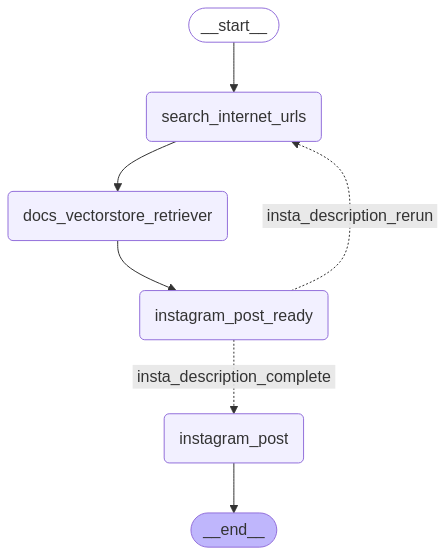

In [3]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

## execution

In [16]:
default_urls=[]
state= graph.invoke({"topic":"Grok 3 Ai seems to be the new number 1","def_urls":default_urls})
state

Running DuckDuckGo search for: Grok 3 Ai seems to be the new number 1


 initiating individual url search
Number of chunks: 34


 initiating vector search creation 


split docs ->-> :[Document(metadata={'source': 'https://www.analyticsvidhya.com/blog/2025/02/grok-3-is-now-1-in-chatbot-arena/', 'title': 'Grok-3 (codename "chocolate") is now #1 in Chatbot Arena - Analytics Vidhya', 'description': "Grok-3 sets a new AI benchmark, surpassing 1400 in Chatbot Arena. xAI's latest model outperforms rivals in reasoning, coding, and more.", 'language': 'en'}, page_content='Grok-3 (codename "chocolate") is now #1 in Chatbot Arena - Analytics Vidhya\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nDeepSeek\n\n\nLearning Paths\n\n\n\nGenAI Pinnacle Plus Program\nNew\n\n\nAgentic AI Pioneer Program\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLogin\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n      





  If everything is fine press Y OR to Rerun the creation press R any other letter will stop
 y






  Instagram Posting.....







  Instagram logging in.....



nikithanupkumar1@gmail.com Dragonprayer2




  Instagram logged in..<instagrapi.Client object at 0x135c09310>...







  Image found .....



Most recent image: elon-musk-to-launch-grok-to-replace-google-bard-and-chatgpt-1710739641-1730447790.png, Date Added: 2025-02-18 14:07:04




  Uploading to Insta.....







  Upload status pk=3570600851488649699 id='3570600851488649699_57087131548' code='DGNUo57sDHj' taken_at=datetime.datetime(2025, 2, 18, 8, 53, 32, tzinfo=TzInfo(UTC)) media_type=1 image_versions2={'candidates': [{'width': 1080, 'height': 1080, 'url': 'https://instagram.fblr5-1.fna.fbcdn.net/v/t51.2885-15/480349533_17957573072899549_286138009791339132_n.jpg?se=7&stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6ImltYWdlX3VybGdlbi4xMDgweDEwODAuc2RyLmY3NTc2MS5kZWZhdWx0X2ltYWdlIn0&_nc_ht=instagram.fblr5-1.fna.fbcdn.net&_nc_cat=101&_nc_oc=Q6cZ2AFvB7p-GQ9qmABQ5UeGjNOLjipSvf9P4wt8kfe4A0yo_6F4YxokLyhj019VOW_QFmM&_nc_ohc=Yu

{'topic': 'Grok 3 Ai seems to be the new number 1',
 'def_urls': ['https://www.analyticsvidhya.com/blog/2025/02/grok-3-is-now-1-in-chatbot-arena/',
  'https://interestingengineering.com/culture/elon-musk-unveils-grok-3-ai',
  'https://beebom.com/elon-musk-unveils-grok-3-reasoning-model-beats-o3-mini-deepseek-r1/'],
 'urls': ['https://www.analyticsvidhya.com/blog/2025/02/grok-3-is-now-1-in-chatbot-arena/',
  'https://interestingengineering.com/culture/elon-musk-unveils-grok-3-ai',
  'https://beebom.com/elon-musk-unveils-grok-3-reasoning-model-beats-o3-mini-deepseek-r1/'],
 'fetch_llm_data': "That's correct! According to the article, Grok-3 has officially secured the #1 spot in Chatbot Arena, marking a historic achievement in artificial intelligence. It has surpassed a score of 1400, setting a new benchmark for large language models (LLMs). This is a significant milestone for xAI and its chatbot models, demonstrating their capabilities in reasoning, coding, and other areas.",
 'instagram

## instagram execution(if needed seperately)

In [9]:
import os
import time
import base64
from datetime import datetime
from pathlib import Path
from PIL import Image
from instagrapi import Client

def instagram_post(descr):
    print("\n\n\n\n  Instagram Posting.....\n\n\n")
    print("\n\n\n\n  Instagram logging in.....\n\n\n")
    
    def insta_login():
        print(os.getenv('INSTA_USER'), os.getenv('INSTA_PASSWORD'))
        cl = Client()
        cl.login(os.getenv('INSTA_USER'), os.getenv('INSTA_PASSWORD'))
        return cl
    
    bot = insta_login()
    print(f"\n\n\n\n  Instagram logged in..{bot}...\n\n\n")

    def random_number_from_epoch():
        epoch_time_seconds = int(time.time())
        epoch_time_string = str(epoch_time_seconds)
        epoch_time_bytes = epoch_time_string.encode('utf-8')
        base32_encoded_time = base64.b32encode(epoch_time_bytes).decode('utf-8')
        return base32_encoded_time
    
    def insta_img_rsz(path):
        rn_str = None  # Initialize rn_str
        try:
            image = Image.open(path)
            image = image.convert("RGB")
            new_image = image.resize((1080, 1080))
            rn_str = random_number_from_epoch()
            new_image.save(f"img_data/{rn_str}.jpg")
        except Exception as e:
            print(f'Error -> {e}')
        return f"img_data/{rn_str}.jpg" if rn_str else None
    
    def insta_upload(bot, phot_path, descr):
        path = insta_img_rsz(phot_path)
        if path:
            return bot.photo_upload(path, descr)
        else:
            print("Failed to resize image.")
            return None
    
    def fetch_most_recent_image(folder_path):
        folder = Path(folder_path)
        if not folder.exists() or not folder.is_dir():
            print(f"The folder {folder_path} does not exist or is not a directory.")
            return None
        most_recent_image = None
        most_recent_date = None
        for file in folder.iterdir():
            if file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']:
                creation_time = file.stat().st_ctime
                if most_recent_image is None or creation_time > most_recent_date:
                    most_recent_image = file.name
                    most_recent_date = creation_time
        if most_recent_image:
            creation_date = datetime.fromtimestamp(most_recent_date).strftime('%Y-%m-%d %H:%M:%S')
            return most_recent_image, creation_date
        else:
            return None
    
    folder_path = 'instaupload'
    recent_image = fetch_most_recent_image(folder_path)
    print("\n\n\n\n  Image found .....\n\n\n")

    if recent_image:
        image_name, creation_date = recent_image
        print(f"Most recent image: {image_name}, Date Added: {creation_date}")
    else:
        print("No images found in the folder.")
        return
    
    print("\n\n\n\n  Uploading to Insta.....\n\n\n")

    phot_path = 'instaupload/' + image_name
    if descr:
        path = insta_upload(bot, phot_path, descr)
    else:
        print(f"\n\n\n\n  No insta description found.....\n\n\n")
    print(f"\n\n\n\n  Upload status {path}.....\n\n\n")

descr = """**"Game Changer Alert!"**

Meet Cerebras Systems, the newcomer shaking things up in AI hardware!

• **4 Trillion Transistors**: That's right, 4 trillion tiny computing units packed into one powerful engine!
• **9,000 Cores**: Handle complex computations with ease and speed.
• **125 Petaflops Capacity**: The ultimate benchmark for AI processing power.

But that's not all! Cerebras' wafer-scale engine (WSE) is designed to revolutionize AI inference, enabling AI to learn on the fly and make logical results from live data.

**The Competition Heats Up!**

NVIDIA, a major player in AI hardware, is taking notice. But don't count out NVIDIA just yet - they're investing heavily in their own AI research and development efforts!

Stay tuned for more updates on this exciting battle between Cerebras Systems and NVIDIA!

#AIHardware #CerebrasSystems #NVIDIA #ArtificialIntelligence #Innovation"""
instagram_post(descr)





  Instagram Posting.....







  Instagram logging in.....



nikithanupkumar1@gmail.com Dragonprayer2




  Instagram logged in..<instagrapi.Client object at 0x135c0f310>...







  Image found .....



Most recent image: Cerebras_logo_in_jpeg_format_for_a_black_background.png, Date Added: 2025-02-12 19:35:44




  Uploading to Insta.....







  Upload status pk=3566418462810101048 id='3566418462810101048_57087131548' code='DF-drI8MNU4' taken_at=datetime.datetime(2025, 2, 12, 14, 23, 52, tzinfo=TzInfo(UTC)) media_type=1 image_versions2={'candidates': [{'width': 1080, 'height': 1080, 'url': 'https://instagram.fblr5-1.fna.fbcdn.net/v/t51.2885-15/477205932_17956863431899549_8256791056808356304_n.jpg?se=7&stp=dst-jpg_e35_tt6&efg=eyJ2ZW5jb2RlX3RhZyI6ImltYWdlX3VybGdlbi4xMDgweDEwODAuc2RyLmY3NTc2MS5kZWZhdWx0X2ltYWdlIn0&_nc_ht=instagram.fblr5-1.fna.fbcdn.net&_nc_cat=101&_nc_oc=Q6cZ2AHKBCO5hwd66Y_vzulvBihT70cKHW3niOgAIXylvxX8hVBXhY_UatAsEsUNoDeG7hc&_nc_ohc=EzZ_8FFzGE4Q7kNvgFogCgS&_nc_gi

## delete

In [ ]:
def fetch_all_media_ids(cl):
    try:
        # Fetch the user's media (posts)
        user_id = cl.user_id  # Get the user ID of the logged-in account
        medias = cl.user_medias(user_id, amount=20)  # Fetch the last 20 posts (adjust amount as needed)

        # Extract media IDs
        media_ids = [media.id for media in medias]
        return media_ids
    except Exception as e:
        print(f"An error occurred while fetching media IDs: {e}")
        return []

def fetch_media_details(cl, media_id):
    try:
        # Fetch the media object using the media ID
        media_info = cl.media_info(media_id)
        
        # Extract and print details
        media = media_info.dict()  # Convert the media object to a dictionary
        print("\nID->"+media_id)
        print(f"\ndescription -> {media['caption_text']}")
        return media
    except Exception as e:
        print(f"An error occurred while fetching media details: {e}")
        return None

def delete_post(cl, media_id):
    try:
        cl.media_delete(media_id)
        print(f"Post with ID {media_id} has been deleted successfully.")
    except Exception as e:
        print(f"An error occurred while deleting the post: {e}")

# Example usage
# media_ids = fetch_all_media_ids(bot)

# # Fetch and print details for each media ID
# for media_id in media_ids:
#     fetch_media_details(bot, media_id)
# media_ids = fetch_all_media_ids(bot)
# media_ids
delete_post(bot, "3565615716964416911_57087131548")

